In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import re
import pickle
from time import time
import tensorflow as tf
import collections
from tensorflow.keras.applications.resnet import ResNet50,preprocess_input,decode_predictions
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.layers import concatenate

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [5]:
captions = readTextFile("C:/Users/shuba/Desktop/SOURCE CODE/DATASET/captions.txt")
captions = captions.split('\n')[1:-1]

In [6]:
description ={}
train_count = 0
count = 0
for x in captions:
    if count >= 20232:
        break 
    first,second = x[:25],x[25:]
    img_name = first.split(".")[0]
    print(first,second)
    if description.get(img_name) is None:
        description[img_name]= []
    description[img_name].append(second)
    count += 1

1000268201_693b08cb0e.jpg ,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg ,A girl going into a wooden building .
1000268201_693b08cb0e.jpg ,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg ,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg ,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg ,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg ,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg ,A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg ,Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg ,Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg ,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b742ab4b8.jp

In [7]:
for x in captions[count:]:  # Start from where the previous loop left off
    first, second = x[:25], x[25:]
    img_name = first.split(".")[0]
    print(first, second)

    if description.get(img_name) is None:
        description[img_name] = []
    description[img_name].append(second)

3106562372_e349a27764.jpg ,A young girl is jumping on carpet while another girl standing in front of her looks to the left .
3106562372_e349a27764.jpg ,The two little girls jump on the bed .
3106562372_e349a27764.jpg ,Two little girls jump above the floor .
3106782647_b078830a9e.jpg ,A bike rider is airborne with a daytime sky in the background .
3106782647_b078830a9e.jpg ,a bmx rider gets a lot of air .
3106782647_b078830a9e.jpg ,A male airborne on a bicycle .
3106782647_b078830a9e.jpg ,The man is performing a trick with a bicycle high in the air .
3106782647_b078830a9e.jpg ,The teen jumps the hill with his bicycle .
3106787167_e5f2312622.jpg ,A man with mud on his clothes protects a ball from two other men while he runs down the field .
3106787167_e5f2312622.jpg ,Dirty rugby players try to hold back the man with the ball .
3106787167_e5f2312622.jpg ,Group of dirty men play football .
3106787167_e5f2312622.jpg ,Three men are playing rugby one of them is carring the ball they are cover

In [8]:
description["1000268201_693b08cb0e"]

[',A child in a pink dress is climbing up a set of stairs in an entry way .',
 ',A girl going into a wooden building .',
 ',A little girl climbing into a wooden playhouse .',
 ',A little girl climbing the stairs to her playhouse .',
 ',A little girl in a pink dress going into a wooden cabin .']

In [9]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split("#")
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [10]:
clean_text('#4\tA little girl in a pink dress going into a wooden cabin .')

' a little girl in a pink dress going into a wooden cabin '

In [11]:
image_list = []
for key,caption_list in description.items():
    image_list.append(key)
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [12]:
image_list

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615',
 '1007320043_627395c3d8',
 '1009434119_febe49276a',
 '1012212859_01547e3f17',
 '1015118661_980735411b',
 '1015584366_dfcec3c85a',
 '101654506_8eb26cfb60',
 '101669240_b2d3e7f17b',
 '1016887272_03199f49c4',
 '1019077836_6fc9b15408',
 '1019604187_d087bf9a5f',
 '1020651753_06077ec457',
 '1022454332_6af2c1449a',
 '1022454428_b6b660a67b',
 '1022975728_75515238d8',
 '102351840_323e3de834',
 '1024138940_f1fefbdce1',
 '102455176_5f8ead62d5',
 '1026685415_0431cbf574',
 '1028205764_7e8df9a2ea',
 '1030985833_b0902ea560',
 '103106960_e8a41d64f8',
 '103195344_5d2dc613a3',
 '103205630_682ca7285b',
 '1032122270_ea6f0beedb',
 '1032460886_4a598ed535',
 '1034276567_49bb87c51c',
 '104136873_5b5d41be75',
 '1042020065_fb3d3ba5ba',
 '1042590306_95dea0916c',
 '1045521051_108ebc19be',
 '1048710776_bb5b0a5c7c',
 '1052358063_eae6744153',
 '105342180_4d4a40b47f',
 '1053804096_ad278b25

In [13]:
with open("C:/Users/shuba/Desktop/SOURCE CODE/DATASET/description_1.txt","w") as f:
    f.write(str(description))

In [14]:
total_words = [ ]

for key in description.keys():
    [total_words.append(i) for des in description[key] for i in des.split()]

In [15]:
counter = collections.Counter(total_words)

In [16]:
freq_cnt = dict(counter)

In [17]:
sorted_freq_counter = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
threshold = 10
sorted_freq_counter = [x for x in sorted_freq_counter if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_counter]

In [18]:
len(image_list)

8091

In [19]:
train = image_list[:6091]
test = image_list[6091:]

In [20]:
train_description = {}
for img_id in train:
    train_description[img_id] = []
    for cap in description[img_id]:
        cap_to_append = "startseq "+ cap +" endseq"
        train_description[img_id].append(cap_to_append)

In [21]:
train_description['1042590306_95dea0916c']

['startseq  a man and woman pose for the camera while another man looks on  endseq',
 'startseq  a man is holding the hand of a woman up to his mouth in front of some buildings while another man looks on  endseq',
 'startseq  a multiracial couple posing for a picture endseq',
 'startseq  asian man and blond woman holding hands outdoors man in background watches  endseq',
 'startseq  guy in blue shirt biting hand of girl in black striped jacket while another guy watches endseq']

In [22]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))

In [23]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [24]:
model_new = Model(model.input,model.layers[-2].output)

In [25]:
def preProcess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    img = preprocess_input(img)
    return img

In [26]:
def encode_imag(img):
    img = preProcess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [27]:
#start = time()
#encoding_train = {}
#for ix,img_id in enumerate(train):
    #if ix >= 4050:
        #break  # Exit the loop if 4050 images have been processed
    #img_path = "C:/Users/shuba/Desktop/SOURCE CODE/model/DATASET/images/"+img_id+".jpg"
    #encoding_train[img_id]=encode_imag(img_path)
    #if ix%100 == 0:
        #print("Encoding in Progress Time step %d "%ix)
#end_t = time()
#print("Total Time Taken :",end_t-start)
from time import time
start = time()
encoding_train = {}
for ix in range(0, 1000):  # Process images 0 to 1000
    img_id = train[ix]
    img_path = "C:/Users/shuba/Desktop/SOURCE CODE/DATASET/images/"+img_id+".jpg"
    encoding_train[img_id] = encode_imag(img_path)
    if ix % 100 == 0:
        print("Encoding in Progress Time step %d " % ix)

1/1 [==============================] - 4s 4s/step
Encoding in Progress Time step 0 
1/1 [==============================] - 0s 153ms/step
Encoding in Progress Time step 100 
1/1 [==============================] - 0s 184ms/step
Encoding in Progress Time step 200 
1/1 [==============================] - 0s 146ms/step
Encoding in Progress Time step 300 
1/1 [==============================] - 0s 150ms/step
Encoding in Progress Time step 400 
1/1 [==============================] - 0s 230ms/step
Encoding in Progress Time step 500 
1/1 [==============================] - 0s 244ms/step
Encoding in Progress Time step 600 
1/1 [==============================] - 0s 155ms/step
Encoding in Progress Time step 700 
1/1 [==============================] - 0s 171ms/step
Encoding in Progress Time step 800 
1/1 [==============================] - 0s 172ms/step
Encoding in Progress Time step 900 
1/1 [==============================] - 0s 160ms/step


In [28]:
for ix in range(1000, 2000):  # Process images 1000 to 2000
    img_id = train[ix]
    img_path = "C:/Users/shuba/Desktop/SOURCE CODE/DATASET/images/"+img_id+".jpg"
    encoding_train[img_id] = encode_imag(img_path)
    if ix % 100 == 0:
        print("Encoding in Progress Time step %d " % ix)

1/1 [==============================] - 0s 149ms/step
Encoding in Progress Time step 1000 
1/1 [==============================] - 0s 146ms/step
Encoding in Progress Time step 1100 
1/1 [==============================] - 0s 174ms/step
Encoding in Progress Time step 1200 
1/1 [==============================] - 0s 138ms/step
Encoding in Progress Time step 1300 
1/1 [==============================] - 0s 152ms/step
Encoding in Progress Time step 1400 
1/1 [==============================] - 0s 238ms/step
Encoding in Progress Time step 1500 
1/1 [==============================] - 0s 183ms/step
Encoding in Progress Time step 1600 
1/1 [==============================] - 0s 140ms/step
Encoding in Progress Time step 1700 
1/1 [==============================] - 0s 151ms/step
Encoding in Progress Time step 1800 
1/1 [==============================] - 0s 165ms/step
Encoding in Progress Time step 1900 
1/1 [==============================] - 0s 154ms/step


In [29]:
for ix in range(2000, 3000):
    img_id = train[ix]
    img_path = "C:/Users/shuba/Desktop/SOURCE CODE/DATASET/images/"+img_id+".jpg"
    encoding_train[img_id] = encode_imag(img_path)
    if ix % 100 == 0:
        print("Encoding in Progress Time step %d " % ix)

1/1 [==============================] - 0s 194ms/step
Encoding in Progress Time step 2000 
1/1 [==============================] - 0s 217ms/step
Encoding in Progress Time step 2100 
1/1 [==============================] - 0s 136ms/step
Encoding in Progress Time step 2200 
1/1 [==============================] - 0s 171ms/step
Encoding in Progress Time step 2300 
1/1 [==============================] - 0s 185ms/step
Encoding in Progress Time step 2400 
1/1 [==============================] - 0s 166ms/step
Encoding in Progress Time step 2500 
1/1 [==============================] - 0s 156ms/step
Encoding in Progress Time step 2600 
1/1 [==============================] - 0s 178ms/step
Encoding in Progress Time step 2700 
1/1 [==============================] - 0s 163ms/step
Encoding in Progress Time step 2800 
1/1 [==============================] - 0s 209ms/step
Encoding in Progress Time step 2900 
1/1 [==============================] - 0s 173ms/step


In [30]:
for ix in range(3000, 4000):
    img_id = train[ix]
    img_path = "C:/Users/shuba/Desktop/SOURCE CODE/DATASET/images/"+img_id+".jpg"
    encoding_train[img_id] = encode_imag(img_path)
    if ix % 100 == 0:
        print("Encoding in Progress Time step %d " % ix)

1/1 [==============================] - 0s 174ms/step
Encoding in Progress Time step 3000 
1/1 [==============================] - 0s 153ms/step
Encoding in Progress Time step 3100 
1/1 [==============================] - 0s 175ms/step
Encoding in Progress Time step 3200 
1/1 [==============================] - 0s 166ms/step
Encoding in Progress Time step 3300 
1/1 [==============================] - 0s 146ms/step
Encoding in Progress Time step 3400 
1/1 [==============================] - 0s 266ms/step
Encoding in Progress Time step 3500 
1/1 [==============================] - 0s 313ms/step
Encoding in Progress Time step 3600 
1/1 [==============================] - 0s 175ms/step
Encoding in Progress Time step 3700 
1/1 [==============================] - 0s 169ms/step
Encoding in Progress Time step 3800 
1/1 [==============================] - 0s 169ms/step
Encoding in Progress Time step 3900 
1/1 [==============================] - 0s 168ms/step


In [31]:
for ix in range(4000, 5000):  
    img_id = train[ix]
    img_path = "C:/Users/shuba/Desktop/SOURCE CODE/DATASET/images/"+img_id+".jpg"
    encoding_train[img_id] = encode_imag(img_path)
    if ix % 100 == 0:
        print("Encoding in Progress Time step %d " % ix)

1/1 [==============================] - 0s 172ms/step
Encoding in Progress Time step 4000 
1/1 [==============================] - 0s 151ms/step
Encoding in Progress Time step 4100 
1/1 [==============================] - 0s 242ms/step
Encoding in Progress Time step 4200 
1/1 [==============================] - 0s 177ms/step
Encoding in Progress Time step 4300 
1/1 [==============================] - 0s 169ms/step
Encoding in Progress Time step 4400 
1/1 [==============================] - 0s 165ms/step
Encoding in Progress Time step 4500 
1/1 [==============================] - 0s 160ms/step
Encoding in Progress Time step 4600 
1/1 [==============================] - 0s 157ms/step
Encoding in Progress Time step 4700 
1/1 [==============================] - 0s 182ms/step
Encoding in Progress Time step 4800 
1/1 [==============================] - 0s 248ms/step
Encoding in Progress Time step 4900 
1/1 [==============================] - 0s 150ms/step


In [32]:
for ix in range(5000, 6000): 
    img_id = train[ix]
    img_path = "C:/Users/shuba/Desktop/SOURCE CODE/DATASET/images/"+img_id+".jpg"
    encoding_train[img_id] = encode_imag(img_path)
    if ix % 100 == 0:
        print("Encoding in Progress Time step %d " % ix)

1/1 [==============================] - 0s 164ms/step
Encoding in Progress Time step 5000 
1/1 [==============================] - 0s 158ms/step
Encoding in Progress Time step 5100 
1/1 [==============================] - 0s 165ms/step
Encoding in Progress Time step 5200 
1/1 [==============================] - 0s 181ms/step
Encoding in Progress Time step 5300 
1/1 [==============================] - 0s 144ms/step
Encoding in Progress Time step 5400 
1/1 [==============================] - 0s 149ms/step
Encoding in Progress Time step 5500 
1/1 [==============================] - 0s 264ms/step
Encoding in Progress Time step 5600 
1/1 [==============================] - 0s 150ms/step
Encoding in Progress Time step 5700 
1/1 [==============================] - 0s 147ms/step
Encoding in Progress Time step 5800 
1/1 [==============================] - 0s 170ms/step
Encoding in Progress Time step 5900 
1/1 [==============================] - 0s 162ms/step


In [33]:
#for ix in range(6000, 7000): 
  #  img_id = train[ix]
  #  img_path = "C:/Users/shuba/Desktop/SOURCE CODE/model/DATASET/images/"+img_id+".jpg"
   # encoding_train[img_id] = encode_imag(img_path)
    #if ix % 100 == 0:
    #    print("Encoding in Progress Time step %d " % ix)

In [34]:
#for ix in range(7000, 8000): 
    #img_id = train[ix]
    #img_path = "C:/Users/shuba/Desktop/SOURCE CODE/model/DATASET/images/"+img_id+".jpg"
    #encoding_train[img_id] = encode_imag(img_path)
    #if ix % 100 == 0:
        #print("Encoding in Progress Time step %d " % ix)

In [35]:
for ix in range(6000,len(train)):
  # Process remaining images (if any)
    img_id = train[ix]
    img_path = "C:/Users/shuba/Desktop/SOURCE CODE/DATASET/images/"+img_id+".jpg"
    encoding_train[img_id] = encode_imag(img_path)
    if ix % 100 == 0:
        print("Encoding in Progress Time step %d " % ix)
end_t = time()
print("Total Time Taken :", end_t - start)

1/1 [==============================] - 0s 175ms/step
Encoding in Progress Time step 6000 
1/1 [==============================] - 0s 139ms/step
Total Time Taken : 1824.5952289104462


In [36]:
with open('C:/Users/shuba/Desktop/SOURCE CODE/model/saved/encoded_train.pkl',"wb") as f:
    pickle.dump(encoding_train,f)

In [37]:
#start = time()
#encoding_test = {}
#for ix,img_id in enumerate(test):
    #img_path = "C:/Users/shuba/Desktop/SOURCE CODE/model/DATASET/images/"+img_id+".jpg"
    #encoding_test[img_id]=encode_imag(img_path)
    #if ix%100 == 0:
        #print("Test Encoding in Progress Time step %d "%ix)

#end_t = time()
#print("Total Time Taken(test) :",end_t-start)
start = time()
encoding_test = {}
for ix in range(0, 1000):  # Process images 0 to 1157
    img_id = test[ix]
    img_path = "C:/Users/shuba/Desktop/SOURCE CODE/DATASET/images/"+img_id+".jpg"
    encoding_test[img_id] = encode_imag(img_path)
    if ix % 100 == 0:
        print("Encoding in Progress Time step %d " % ix)

1/1 [==============================] - 0s 247ms/step
Encoding in Progress Time step 0 
1/1 [==============================] - 0s 230ms/step
Encoding in Progress Time step 100 
1/1 [==============================] - 0s 162ms/step
Encoding in Progress Time step 200 
1/1 [==============================] - 0s 165ms/step
Encoding in Progress Time step 300 
1/1 [==============================] - 0s 167ms/step
Encoding in Progress Time step 400 
1/1 [==============================] - 0s 139ms/step
Encoding in Progress Time step 500 
1/1 [==============================] - 0s 168ms/step
Encoding in Progress Time step 600 
1/1 [==============================] - 0s 136ms/step
Encoding in Progress Time step 700 
1/1 [==============================] - 0s 307ms/step
Encoding in Progress Time step 800 
1/1 [==============================] - 0s 147ms/step
Encoding in Progress Time step 900 
1/1 [==============================] - 0s 184ms/step


In [38]:
for ix in range(1000, 2000): 
    img_id = test[ix]
    img_path = "C:/Users/shuba/Desktop/SOURCE CODE/DATASET/images/"+img_id+".jpg"
    encoding_test[img_id] = encode_imag(img_path)
    if ix % 100 == 0:
        print("Encoding in Progress Time step %d " % ix)

1/1 [==============================] - 0s 155ms/step
Encoding in Progress Time step 1000 
1/1 [==============================] - 0s 186ms/step
Encoding in Progress Time step 1100 
1/1 [==============================] - 0s 203ms/step
Encoding in Progress Time step 1200 
1/1 [==============================] - 0s 145ms/step
Encoding in Progress Time step 1300 
1/1 [==============================] - 0s 179ms/step
Encoding in Progress Time step 1400 
1/1 [==============================] - 0s 183ms/step
Encoding in Progress Time step 1500 
1/1 [==============================] - 0s 165ms/step
Encoding in Progress Time step 1600 
1/1 [==============================] - 0s 144ms/step
Encoding in Progress Time step 1700 
1/1 [==============================] - 0s 181ms/step
Encoding in Progress Time step 1800 
1/1 [==============================] - 0s 163ms/step
Encoding in Progress Time step 1900 
1/1 [==============================] - 0s 171ms/step


In [39]:
#for ix in range(2000, 3000): 
    #img_id = test[ix]
    #img_path = "C:/Users/shuba/Desktop/SOURCE CODE/model/DATASET/images/"+img_id+".jpg"
    #encoding_test[img_id] = encode_imag(img_path)
    #if ix % 100 == 0:
        #print("Encoding in Progress Time step %d " % ix)

In [40]:
#for ix in range(3000, 4000): 
    #img_id = test[ix]
    #img_path = "C:/Users/shuba/Desktop/SOURCE CODE/model/DATASET/images/"+img_id+".jpg"
    #encoding_test[img_id] = encode_imag(img_path)
    #if ix % 100 == 0:
        #print("Encoding in Progress Time step %d " % ix)

In [41]:
#for ix in range(4000, 5000): 
    #img_id = test[ix]
    #img_path = "C:/Users/shuba/Desktop/SOURCE CODE/model/DATASET/images/"+img_id+".jpg"
    #encoding_test[img_id] = encode_imag(img_path)
    #if ix % 100 == 0:
        #print("Encoding in Progress Time step %d " % ix)

In [42]:
#for ix in range(5000, 6000): 
    #img_id = test[ix]
    #img_path = "C:/Users/shuba/Desktop/SOURCE CODE/model/DATASET/images/"+img_id+".jpg"
    #encoding_test[img_id] = encode_imag(img_path)
    #if ix % 100 == 0:
        #print("Encoding in Progress Time step %d " % ix)

In [43]:
for ix in range(2000,len(test)):
  # Process remaining images (if any)
    img_id = test[ix]
    img_path = "C:/Users/shuba/Desktop/SOURCE CODE/DATASET/images/"+img_id+".jpg"
    encoding_test[img_id] = encode_imag(img_path)
    if ix % 100 == 0:
        print("Encoding in Progress Time step %d " % ix)
end_t = time()
print("Total Time Taken :", end_t - start)

Total Time Taken : 608.732537984848


In [44]:
with open('C:/Users/shuba/Desktop/SOURCE CODE/model/saved/encoded_test.pkl',"wb") as f:
    pickle.dump(encoding_test,f)

In [45]:
word_to_idx ={}
idx_to_word = {}

In [46]:
for i,words in enumerate(total_words):
    word_to_idx[words] = i+1
    idx_to_word[i+1]= words

In [47]:
idx_to_word[len(total_words)+1] = "startseq"
word_to_idx["startseq"] = len(total_words)+1

In [48]:
idx_to_word[len(total_words)+2] = "endseq"
word_to_idx["endseq"] = len(total_words)+2

vocab_size = len(word_to_idx) + 1
print(vocab_size)

1854


In [49]:
max_len = 0
for key in train_description.keys():
    for cap in train_description[key]:
        max_len = max(max_len,len(cap.split()))

In [50]:
print(max_len)

38


In [51]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1), np.array(X2)] , np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [52]:
f = open("C:/Users/shuba/Desktop/SOURCE CODE/DATASET/glove.6B.50d.txt",encoding='utf-8')

In [53]:
embedding_index ={}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word]=word_embedding

In [54]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [55]:
f.close()

In [56]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

In [57]:
embedding_matrix = get_embedding_matrix()

In [58]:
embedding_matrix.shape

(1854, 50)

In [59]:
input_img_features = Input(shape=(2048,))
inp_img1 =Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [60]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [61]:
from tensorflow.keras.layers import concatenate

In [62]:
decoder1 = concatenate([inp_img2,inp_cap3])
decoder2 = Dense(256,activation ='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

f_model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [63]:
f_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 50)       92700       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [64]:
f_model.layers[2].set_weights([embedding_matrix])
f_model.layers[2].trainable =False

In [65]:
f_model.compile(loss = 'categorical_crossentropy',optimizer = 'adam')

In [66]:
f_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 50)       92700       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [67]:
epochs = 20
batch_size = 3
steps = len(train_description)//batch_size

In [68]:
for i in range(epochs):
    generator = data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)

    f_model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    f_model.save('C:/Users/shuba/Desktop/SOURCE CODE/model/model_weights/model_'+str(i)+'.h5')

2030/2030 [==============================] - 547s 270ms/step - loss: 2.2643


In [69]:
with open('C:/Users/shuba/Desktop/SOURCE CODE/model/saved/word_to_idx.pkl',"wb") as f:
    pickle.dump(word_to_idx,f)

In [70]:
with open('C:/Users/shuba/Desktop/SOURCE CODE/model/saved/idx_to_word.pkl',"wb") as f:
    pickle.dump(idx_to_word,f)

In [71]:
def predict_caption(photo):

    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')

        ypred = f_model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)

        if word == "endseq":
            break

    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

1/1 [==============================] - 0s 29ms/step


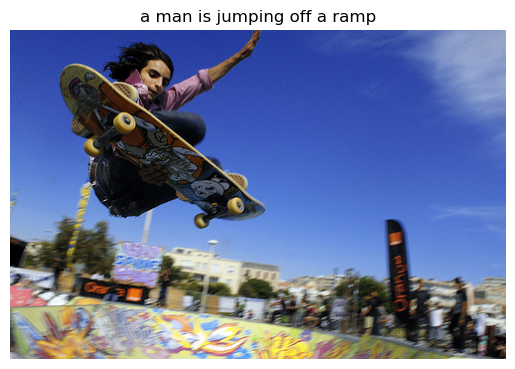

1/1 [==============================] - 0s 32ms/step


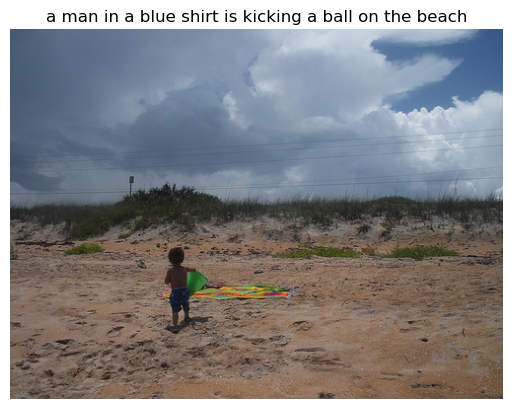

1/1 [==============================] - 0s 32ms/step


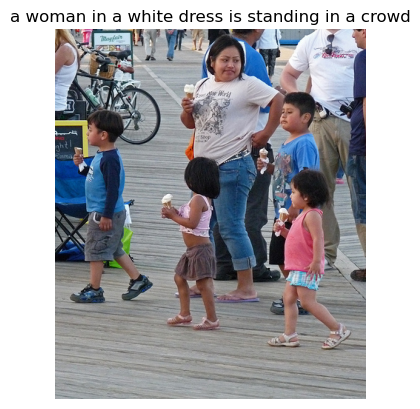

1/1 [==============================] - 0s 32ms/step


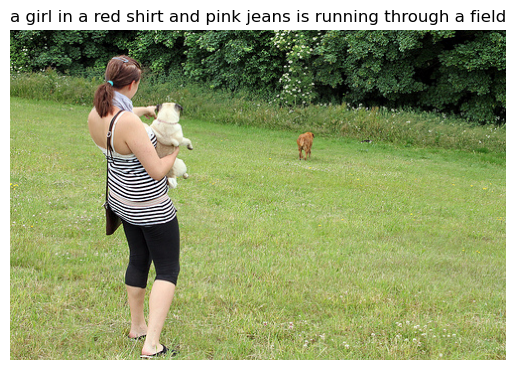

1/1 [==============================] - 0s 32ms/step


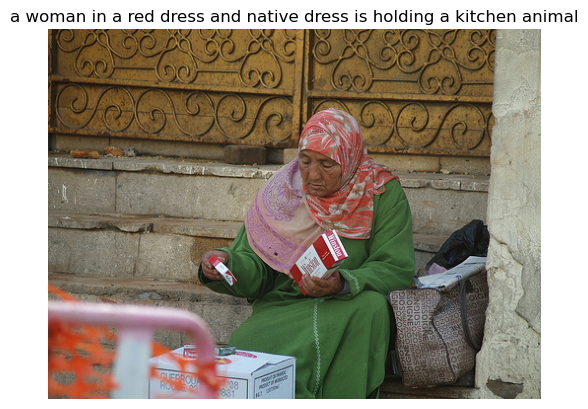

In [73]:
for i in range(5):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = test[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("C:/Users/shuba/Desktop/SOURCE CODE/DATASET/images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()



In [74]:
f_model.save('model_20.h5')